In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Function
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import random
from PIL import Image

from skimage.io import imsave, imread
from skimage.transform import resize
from skimage.transform import rotate
import h5py

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data'

/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data


<h2> 1. Data Preprocessing

In [4]:
hf = h5py.File('Ultrasound_segmentation.h5', 'r')
[key for key in hf.keys()]

['imgs', 'masks']

In [0]:
imgs = hf.get('imgs')
masks = hf.get('masks')

In [6]:
imgs.shape

(5635, 420, 580)

In [7]:
masks.shape

(5635, 420, 580)

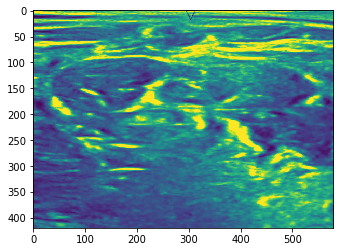

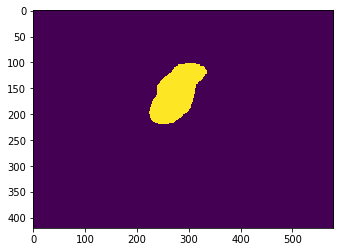

In [8]:
plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(masks[0])

In [0]:
img_rows = 96
img_cols = 96

def imgs_resize(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_rows, img_cols), preserve_range=True)

    return imgs_p

In [0]:
imgs = imgs_resize(imgs)
masks = imgs_resize(masks)

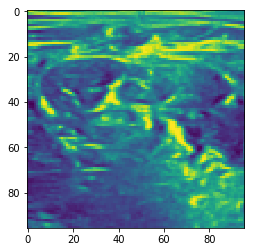

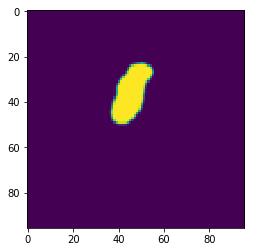

In [11]:
plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(masks[0])

In [0]:
def norm_imgs(imgs):
  imgs = imgs.astype('float32')
  mean = np.mean(imgs)
  std = np.std(imgs)
  
  imgs -= mean
  imgs /= std
  
  return imgs

def norm_masks(masks):
  masks = masks.astype('float32')
  masks /= 255
  
  return masks

In [0]:
imgs = norm_imgs(imgs)
masks = norm_masks(masks)

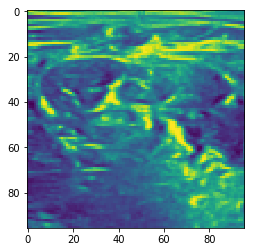

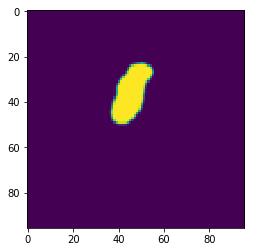

In [14]:
plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(masks[0])

In [0]:
# Expand Dims
imgs = imgs[..., np.newaxis]
masks = masks[..., np.newaxis]

In [0]:
# Channel first
imgs = imgs.transpose(0, 3, 1, 2) # C x H x W format
masks = masks.transpose(0, 3, 1, 2)

In [0]:
# Numpy to tensor
imgs = torch.from_numpy(imgs)
masks = torch.from_numpy(masks)

In [0]:
imgs_train = imgs[:4000]
masks_train = masks[:4000]

imgs_val = imgs[4000:4560]
masks_val = masks[4000:4560]

imgs_test = imgs[4560:]
masks_test = masks[4560:]

In [0]:
imgs_train = TensorDataset(imgs_train, masks_train)
imgs_val = TensorDataset(imgs_val, masks_val)
imgs_test = TensorDataset(imgs_test, masks_test)

In [0]:
trainloader = DataLoader(imgs_train, batch_size=32)
valloader = DataLoader(imgs_val, batch_size=32)
testloader = DataLoader(imgs_test, batch_size=32)

<h2> 2. Model Architecture

In [0]:
# from https://github.com/jakeoung/Unet_pytorch

import torch
import torch.nn as nn
import torch.nn.functional as functional

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def add_merge_stage(ch_coarse, ch_fine, in_coarse, in_fine, upsample):
  conv = nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  torch.cat(conv, in_fine)

  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  )
  upsample(in_coarse)

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class Net(nn.Module):
  def __init__(self, useBN=False):
    super(Net, self).__init__()

    self.conv1   = add_conv_stage(1, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    self.conv5   = add_conv_stage(256, 512, useBN=useBN)

    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)

    self.conv0  = nn.Sequential(
        nn.Conv2d(32, 1, 3, 1, 1),
        nn.Sigmoid()
    )

    self.max_pool = nn.MaxPool2d(2)

    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)

    ## weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()


  def forward(self, x):
    conv1_out = self.conv1(x)
    #return self.upsample21(conv1_out)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))
    conv5_out = self.conv5(self.max_pool(conv4_out))

    conv5m_out = torch.cat((self.upsample54(conv5_out), conv4_out), 1)
    conv4m_out = self.conv4m(conv5m_out)

    conv4m_out_ = torch.cat((self.upsample43(conv4m_out), conv3_out), 1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out = self.conv1m(conv2m_out_)

    conv0_out = self.conv0(conv1m_out)

    return conv0_out

In [0]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net(useBN=True).to(device)
optimizer = optim.Adam(model.parameters())

<h2> 3. Train & Evaluation Functions

In [0]:
dicto = {'train':trainloader, 'val':valloader}

In [0]:
def train_model(model, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        for loader in dicto:
            running_loss = 0
            if loader == 'train':
                model.train()
            else:
                model.eval()
            for t, (x, y) in enumerate(dicto[loader]):
                x = Variable(x.to(device))
                y = Variable(y.to(device))

                output = model(x)

                loss = dice_coef_loss(y, output)
                loss = loss
                running_loss += loss.item()

                optimizer.zero_grad()
                if loader == 'train':
                    loss.backward()
                    optimizer.step()
            print('{} Loss for epoch {} is {}'.format(loader, epoch + 1, float(running_loss) / t))
        print('-' * 10)

In [26]:
train_model(model, optimizer, num_epochs=30)

train Loss for epoch 1 is -0.17539558203462813
val Loss for epoch 1 is -0.3710006068568499
----------
train Loss for epoch 2 is -0.36297688674406553
val Loss for epoch 2 is -0.5203093498335768
----------
train Loss for epoch 3 is -0.41909260019935074
val Loss for epoch 3 is -0.5561423120397033
----------
train Loss for epoch 4 is -0.4484796571277031
val Loss for epoch 4 is -0.4781272238486802
----------
train Loss for epoch 5 is -0.4748524440468417
val Loss for epoch 5 is -0.5256895410335239
----------
train Loss for epoch 6 is -0.49998787596421373
val Loss for epoch 6 is -0.5780142253840014
----------
train Loss for epoch 7 is -0.5101895152335102
val Loss for epoch 7 is -0.5414350461043582
----------
train Loss for epoch 8 is -0.5201948953214132
val Loss for epoch 8 is -0.5871567328474211
----------
train Loss for epoch 9 is -0.5237902742951372
val Loss for epoch 9 is -0.5636413210578373
----------
train Loss for epoch 10 is -0.543275673921603
val Loss for epoch 10 is -0.6101795333978

In [0]:
# save
Path = './weight_segmentation.pt'
torch.save(model.state_dict(), Path)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


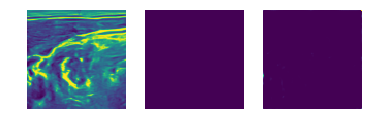

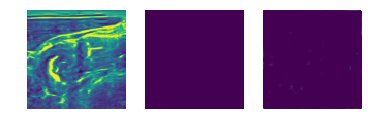

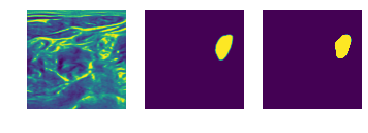

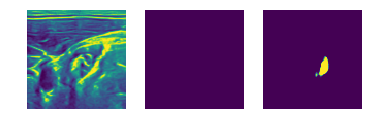

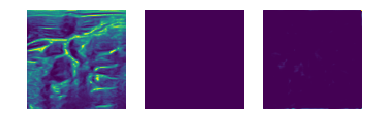

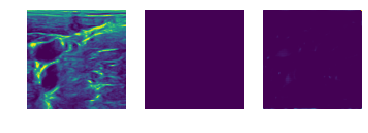

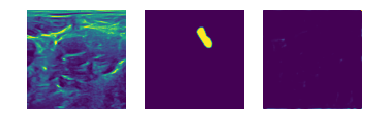

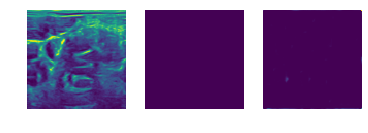

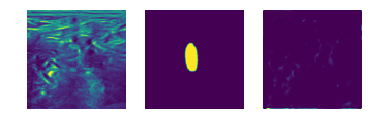

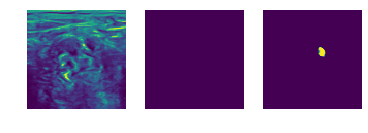

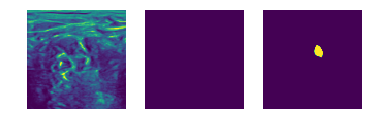

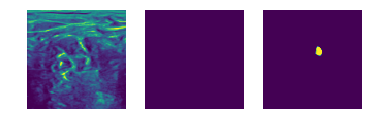

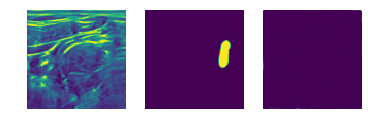

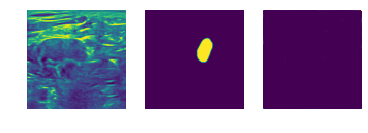

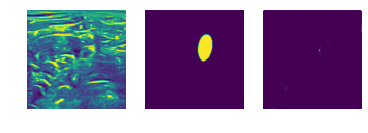

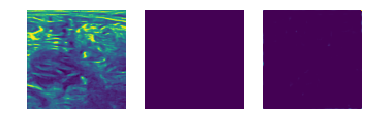

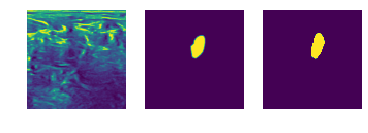

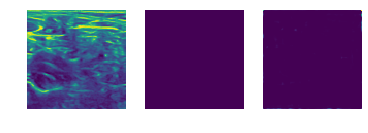

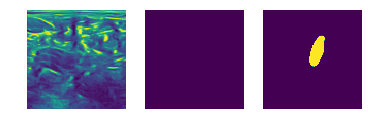

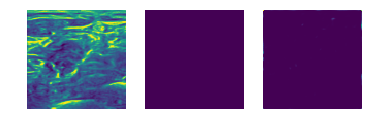

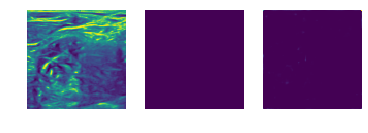

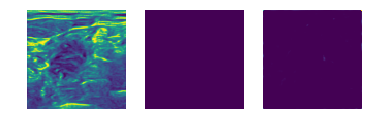

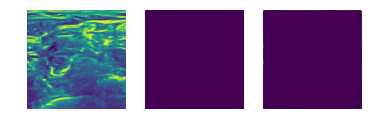

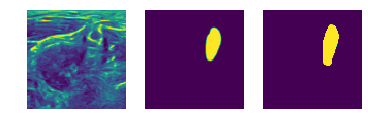

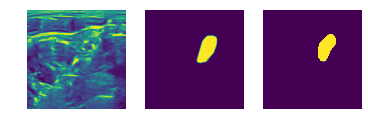

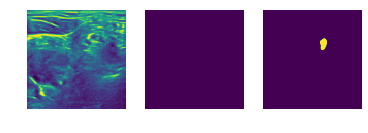

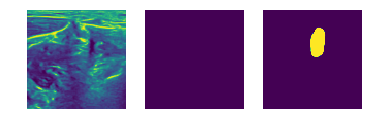

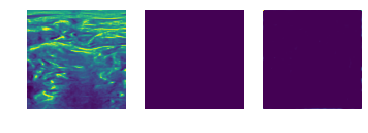

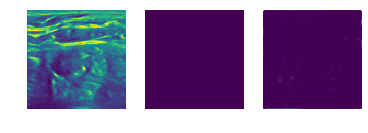

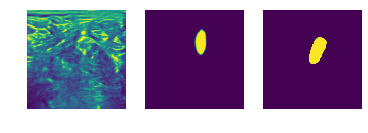

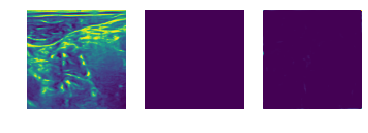

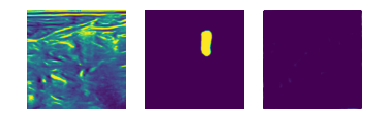

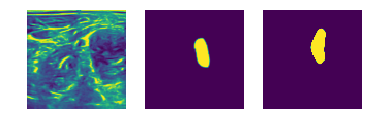

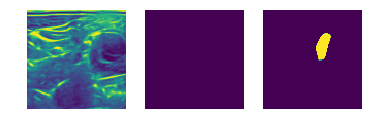

In [31]:
from torchvision.transforms import RandomCrop, Compose, ToPILImage


Loss_sum = 0

for t, (x, y) in enumerate(testloader):
  x = Variable(x).to(device)
  y = Variable(y).to(device)

  output = model(x)

  loss = dice_coef(y, output)
  loss = loss.to(device)
  
  Loss_sum += loss.item()
  
  x = x.data.type(torch.FloatTensor)
  y = y.data.type(torch.FloatTensor)
  output = output.data.type(torch.FloatTensor)
  img_data = x.cpu().numpy()[0,0]
  mask_data = y.cpu().numpy()[0,0]
  output_mask = output.cpu().numpy()[0,0]
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(img_data)
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(mask_data)
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(output_mask)
  plt.axis('off')

In [32]:
No_batches = len(testloader.dataset)//32
print(Loss_sum/No_batches)

0.43943750260002684
